# Authorship Identification - Your Posts vs Bad CEOs'

![Image: image from https://trekkingwithdennis.com/tag/star-trek-voyager/](banner.png "image from trekkingwithdennis.com")

In this article, we will entertian ourselves by comparing our's, and, our galatic leaders' posts on the professional network BeamedIn, againts those of past earthling CEOs who were either frauds or unnanimously declared as unpleasant people. 

We will do this with a technique called **Authorship Identification** in NLP.

This enables us to identify the most likely author of articles, news or messages. 

# Building The Author Learning Pipeline

Here are the steps we will undertake:
1. Clean these articles: stop words, lematize, and normalize.
2. Extract features through bag of word (BoW).
3. Tokenize words
4. Downscale to frequencies from word occurences.
5. Train classifier - for this we will find the best from a group of classifiers.

Let's prepare our notebook before this work

In [1]:
# Pip below for Kaggle and online notebooks.
# !pip install ipywidgets
# !pip install sklearn
# !pip install spacy

# General-purpose Libraries
import os
import numpy as np
import pandas as pd
import sklearn
import re
from collections import Counter
%matplotlib inline

# Remove anywarning texts from notebooks.
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# Discover files in kaggle if any.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = pd.read_csv('./communications.csv')
data = data.dropna()
data.sample(5, random_state=RANDOM_STATE)

,publication,author,content
31675,tweets,Donald Trump,"Just learned that Jon @ Ossoff, who is running..."
41303,tweets,Donald Trump,"With Votes in the House tomorrow, Democrats wa..."
13150,tweets,Donald Trump,"""To become a champion, fight one more round."" ..."
29651,tweets,Donald Trump,"Another attack, this time in Germany. Many kil..."
6425,tweets,Donald Trump,@ rubletz True--isn't it sad!


We will be using `scikit-learn` to create text processing pipelines. A Pipeline will create a compound classifier through these steps:
1. vectorizer
2. transformer
3. classifier

But first we need to explore our data. We can look at the communication peices sizes, frequency of words or general sentiment:

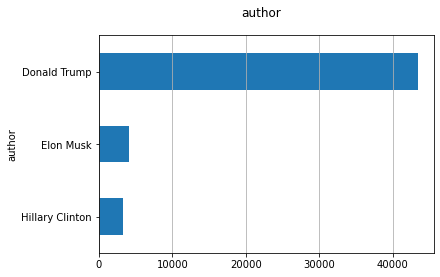

In [2]:
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

fig, ax = plt.subplots()
fig.suptitle("author", fontsize=12)
data["author"].reset_index().groupby("author").count().sort_values(by="index").plot(
  kind="barh", 
  legend=False,
  ax=ax).grid(axis='x')
plt.show()

Comparing to the number of peices in each corpus, we see our dataset is unbalanced.
A resampling be done to normalize the dataset, preferably with a cleanup:
- Drop stopwords (e.g. and, are, what)
- Lemmatize (e.g. driven will become drive, as driver will result in drive)
- Drop common words (i.e. beyond a median frequency)

In [3]:
# Resampled and Normalized
from nltk.stem.wordnet import WordNetLemmatizer
min_rows = data["author"].reset_index().groupby("author").count().min().values[0]

authors = data["author"].unique()
n_df = pd.DataFrame(columns =['author', 'content'])
for author in authors:
  row = data[data["author"] == author].sample(n=min_rows, random_state=1)
  n_df = n_df.append(row[['author', 'content']], ignore_index = True)
n_df = n_df.dropna()

# Tokenize, lemmatize and drop stop words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from collections import Counter

sentim = SentimentIntensityAnalyzer()
stops = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

n_df['n_content'] = n_df["content"].apply(
  lambda x: 
    ' '.join([wnl.lemmatize(token) for token in word_tokenize(x) 
    if token not in stops])
)


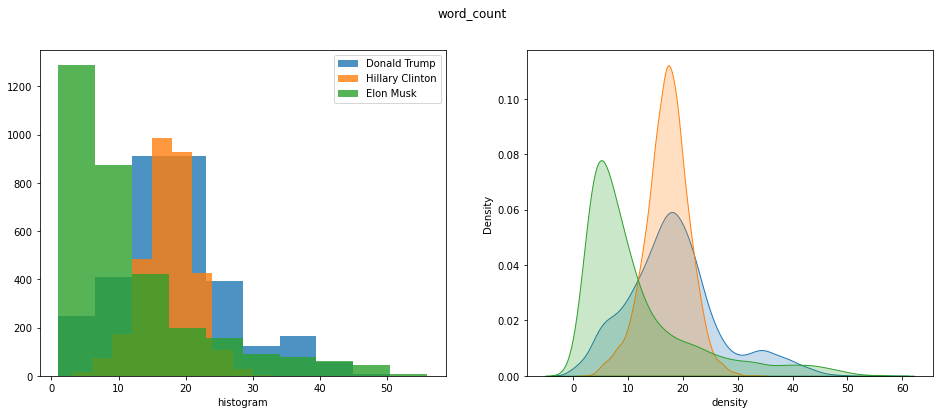

In [4]:
# Analyze length, counts, etc.
n_df['word_count'] = n_df["n_content"].apply(lambda x: len(str(x).split(" ")))
n_df['char_count'] = n_df["n_content"].apply(
    lambda x: sum(len(word) for word in str(x).split(" ")))

x, y = "word_count", "author"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle(x)
for i in authors:
    sns.distplot(n_df[n_df[y] == i][x], hist=True, kde=False,
                 bins=10, hist_kws={"alpha": 0.8},
                 axlabel="histogram", ax=ax[0])
    sns.distplot(n_df[n_df[y] == i][x], hist=False, kde=True,
                 kde_kws={"shade": True}, axlabel="density",
                 ax=ax[1])
ax[0].legend(authors)
plt.show()


There is a common density area of 10 to 30 words for these peices of articles, which we can use to further resample our data to be balanced.

In [5]:
word_df = pd.DataFrame(columns=['author', 'content', 'n_content'])
for author in authors:
  row = n_df[(n_df["author"] == author) & (n_df["word_count"] >= 10) & (n_df["word_count"] <= 30)]
  word_df = word_df.append(row[['author', 'content', 'n_content']], ignore_index=True)
n_df = word_df.dropna()
print(n_df.shape)

(6632, 3)


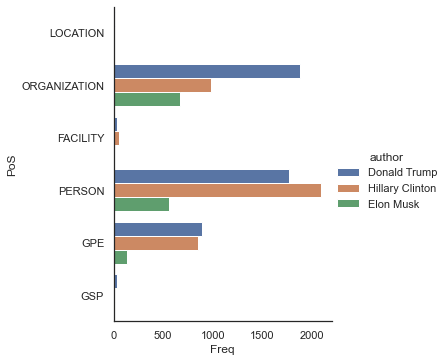

In [6]:

n_df["sentiment"] = n_df['n_content'].apply(
  lambda x:
    sentim.polarity_scores(x)['compound'])

n_df["tags"] = n_df['n_content'].apply(
  lambda x: 
    [t.label() for t in ne_chunk(pos_tag(
      x.split(' '))) if hasattr(t, 'label')])
    
TAG_SET = list(
    set([tag for tags in n_df["tags"] for tag in tags]))
for tag in TAG_SET:
    n_df[tag] = n_df['tags'].map(
        lambda x: x.count(tag) if x is not None and len(x) >= 0 else 0)
n_tags = pd.DataFrame(columns=TAG_SET)
n_df= n_df.drop(columns=["tags"])

sns.set(style="white")
for author in authors:
  temp = pd.DataFrame(n_df[n_df["author"] == author][TAG_SET].sum()).T
  temp['author'] = author
  n_tags = n_tags.append(temp)
temp = n_tags.melt(id_vars="author", var_name="PoS", value_name="Freq")
sns.factorplot(x='Freq', y="PoS", hue="author", data=temp,
               kind='bar', size=5)

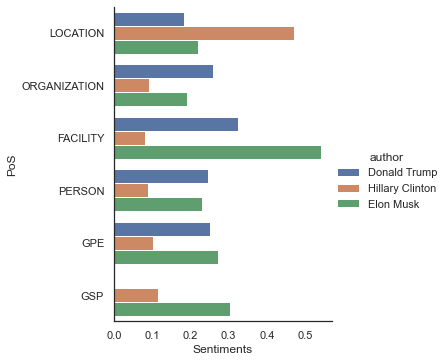

In [7]:
temp = pd.DataFrame(columns=[*TAG_SET, *["author"]])
for author in authors:
  for tag in TAG_SET:
    sent = (n_df[(n_df["author"] == author) & (
        n_df[tag] >= 1)]["sentiment"].mean())
    temp.at[author, tag] = sent if sent > 0 else 0
  temp.at[author, "author"] = author
temp = temp.dropna()

temp = temp.melt(id_vars="author", var_name="PoS", value_name="Sentiments")
sns.factorplot(x='Sentiments', y="PoS", hue="author", data=temp,
               kind='bar', size=5)


What entities do these talk about oftn? NER identifies this, and for our own information, standard NER codes are:
1.	ORGANIZATION e.g. Microsoft, Facebook
2.	PERSON e.g. Rafael Nadal, Nelson Mandela
3.	MONEY e.g. 9 million dollars, INR 4 Crore
4.	GPE e.g. India, Australia, South East Asia
5.  GSP is a Geo-Socio-Political group
5.	LOCATION e.g. Mount Everest, River Ganga
6.	DATE e.g. 9th May 1987, 4 AUG
7.	TIME e.g. 7:23 A.M., three-forty am


Finally, a word cloud to allow us to explore the words themselves and their frequency in relation to the dataset:

Wordcloud for: Donald Trump


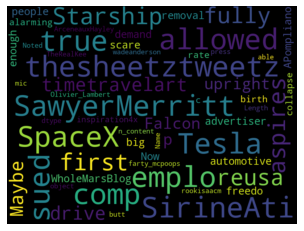

Wordcloud for: Hillary Clinton


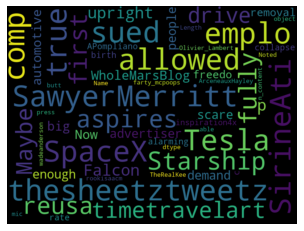

Wordcloud for: Elon Musk


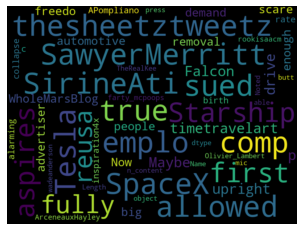

In [8]:
for i in authors:
  print(f'Wordcloud for: {i}')
  
  wc = wordcloud.WordCloud(background_color='black', max_words=200,
                           max_font_size=80, width=800, height=600)

  corpus = n_df[n_df["author"] == author]['n_content']
  wc = wc.generate(text=str(corpus))
  plt.imshow(wc, cmap=None, interpolation='bilinear')
  
  plt.axis("off")
  plt.show()

Now let's build the model.

We will use the vectors derived from the corpus to act as features for our model. Features which we will apply with a stacking classifier to, which will combine the best outputs of each classifier to find an optimal prediction.

In [9]:
# 1
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import *
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download()

# Vectorizing on normalized text above.
vect = CountVectorizer(stop_words='english')
lgc = LogisticRegression(n_jobs=-1)
sgdc = SGDClassifier(loss='hinge',
                     penalty='l2',
                     alpha=1e-3,
                     random_state=RANDOM_STATE,
                     tol=None,
                     n_jobs=-1)
estimators = [('sgdc', sgdc), ('lgc', lgc)]
etc = ExtraTreesClassifier(random_state=RANDOM_STATE)
sclf = StackingClassifier(estimators=estimators,
                          final_estimator=lgc,
                          passthrough=True)
tfidf = TfidfTransformer(use_idf=False)

# Pipeline
n_df = n_df.dropna()
y = n_df['author']
X = n_df['n_content']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__sgdc__alpha': (1e-2, 1e-3),
    'clf__sgdc__tol': (0.0, 1e-3),
    'clf__lgc__solver': ['newton-cg', 'lbfgs', 'sag'],
    'clf__lgc__C': [0.2, 0.5, 1],
    'clf__lgc__penalty': ['c', 'l2']
}

# To find out for the param grid.
# print(text_clf.get_params())
text_clf = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('clf', sclf),
])
gs_clf = GridSearchCV(estimator=text_clf,
                      param_grid=parameters,
                      cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

Let's vet the models we are stacking:

In [ ]:
predicted = gs_clf.predict(X_test)

from sklearn import metrics
print(metrics.classification_report(y_test, predicted,
                                     target_names=y.unique()))

Above 80% is good enough. SKTLearn has a recommendation map below to get the most optimal model:
![Image: image from sktlearn](ml_map.png "image from tsktlearn")

Finally, let's test it on some samples from this same article to find to which bad CEO our text's style mostly resembles, and by how much:

In [ ]:
text = "In this article, we will entertian ourselves by comparing our's, and, our galatic leaders' posts on the professional network BeamedIn, againts those of past earthling CEOs who were either frauds or unnanimously declared as unpleasant people. We will do this with a technique called ** Authorship Identification ** in NLP. This enables us to identify the most likely author of articles, news or messages. "
toks = [wnl.lemmatize(token) for token in word_tokenize(text) if token not in stops]
text_predicted = gs_clf.predict(toks)
text_predicted_prob = gs_clf.predict_proba(toks)

txt = text_predicted[0]
txt_idx = np.where(authors == txt)

probability = text_predicted_prob[0][txt_idx][0]
print(f'This text is something "{txt}" would write at {probability:.0%}')


# Concluding our Analysis



# References

- https://spacy.io

## Github and Kaggle

Article here is also available on [Github]() and [Kaggle]()

#
<div align="right">Made with :heartpulse: by <b>Adam</b></div>